<h1>Решение соревнования kaggle "Porn Detection"</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
import nltk
import pymorphy2
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from tqdm import notebook

In [2]:
def tokenize_text(text):
    return re.findall(r'[\w\d]+', text.lower())

In [4]:
train_df = pd.read_csv("./data/train.csv")

train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [5]:
test_df = pd.read_csv("./data/test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


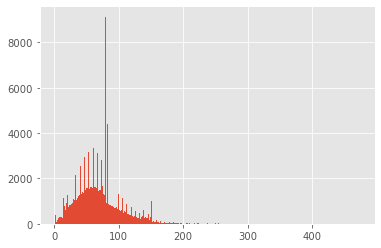

In [6]:
train_df.title.str.len().hist(bins=400)

<h2>Токенизация</h2>

In [7]:
train_df["target"].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [8]:
train_df['url_title'] = train_df['url'] + ' ' + train_df['title']

In [9]:
corpus = train_df.url_title.values
corpus

array(['m.kp.md Экс-министр экономики Молдовы - главе МИДЭИ, цель которого сделать из республики не просителя, а донора: Надо избегать долгого нахождения н�',
       'www.kp.by Эта песня стала известна многим телезрителям благодаря сериалу Диверсант-2',
       'fanserials.tv Банши 4 сезон 2 серия Бремя красоты смотреть онлайн!',
       ...,
       'topclassiccarsforsale.com 1941 Plymouth Special Deluxe Hot Rod, Automatic,Small Block,Power Steering, A/C for sale: photos, technical specifications, description',
       "wowcream.ru Купить It's Skin Сыворотка питательная Power 10 Formula YE Effector, 30 мл в Москве - WOWCREAM",
       'www.ubu.ru Технический спирт в канистрах и флаконах, купить в Москве'],
      dtype=object)

In [10]:
docs = [tokenize_text(text) for text in notebook.tqdm(corpus)]
# docs = [[token.text for token in razdel.tokenize(text)] for text in notebook.tqdm(corpus)]

<h2>Стоп слова</h2>

In [10]:
occurence = Counter()

for doc in notebook.tqdm(docs):
    for token in doc:
        occurence[token] += 1

In [11]:
occurence.most_common(20)

[('ru', 90385),
 ('в', 37542),
 ('www', 25111),
 ('на', 22882),
 ('и', 22716),
 ('com', 22026),
 ('mail', 14722),
 ('онлайн', 11971),
 ('с', 11260),
 ('для', 10174),
 ('net', 8891),
 ('по', 8444),
 ('бесплатно', 8243),
 ('скачать', 7751),
 ('1', 7164),
 ('2', 6471),
 ('фото', 6378),
 ('купить', 6315),
 ('ua', 6091),
 ('страница', 5847)]

In [12]:
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(nltk.corpus.stopwords.words('english'))
stopwords_set = set(stopwords)

In [13]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [14]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in notebook.tqdm(docs)]
# и заодно удалим стоп слова
cleared_docs = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs]

In [15]:
cleared_docs[69024]

['mail',
 'ru',
 'фотография',
 'ღ',
 'ťąŧأąŋǻ',
 'ﱢ',
 'ღ',
 'шелест',
 'ړײ',
 'ip',
 '842',
 'фото',
 'мир']

In [16]:
train_df.sample(5)

,id,url,title,target,url_title
116596,116596,bessporno.tv,Брюнетка позволяет парню ебать жопу и делать а...,True,bessporno.tv Брюнетка позволяет парню ебать жо...
99544,99544,pornotor.org,скачать торрент [chaturbate.com] Misss vikki s...,True,pornotor.org скачать торрент [chaturbate.com] ...
74318,74318,anketolog.ru,Сбор ответов на анкету,False,anketolog.ru Сбор ответов на анкету
113243,113243,lechinle.tk,Thai pone. Xxxxx video girl and horse hd. Lesb...,True,lechinle.tk Thai pone. Xxxxx video girl and ho...
40579,40579,fotostrana.ru,"Тамара: «Подлинная суть человека не в том, что...",False,fotostrana.ru Тамара: «Подлинная суть человека...


In [17]:
cleared_docs[0]

['kp',
 'md',
 'экс',
 'министр',
 'экономика',
 'молдова',
 'глава',
 'мидэи',
 'цель',
 'который',
 'сделать',
 'республика',
 'проситель',
 'донор',
 'избегать',
 'долгий',
 'нахождение',
 'н']

In [18]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_df=0.8, min_df=2, norm='l2')
# vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)

In [19]:
X_train = vectorizer.fit_transform(cleared_docs)

In [20]:
y_train = train_df["target"].astype(int).values

# ML

In [21]:
model = VotingClassifier(estimators = [('forest', RandomForestClassifier(n_estimators=30,
                                                                         min_samples_leaf=1)),
                                       ('logreg', LogisticRegression(solver='liblinear')),
                                       ('bayes', MultinomialNB())], voting='soft')

In [22]:
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_name].values

In [23]:
pipeline = Pipeline([
    (
        'features', 
        FeatureUnion([
            (
                'title', 
                Pipeline([
                    ('extractor', ColumnExtractor('url')),
                    (
                        'vectorizer', 
                        TfidfVectorizer(
                            lowercase=True, ngram_range=(3, 4), token_pattern="[\w\d]+",
                            stop_words=stopwords_set, min_df=5, max_df=0.75, analyzer='char'
                        )
                    )
                ])
            ),
            (
                'body',
                Pipeline([
                    ('extractor', ColumnExtractor('title')),
                    (
                        'vectorizer', 
                        CountVectorizer(
                            lowercase=True, ngram_range=(1, 1), token_pattern="[\w\d]+",
                            stop_words=stopwords_set, min_df=3, max_df=0.75
                        )
                    )
                ])
            )
        ])
    ),
    ('clf', model)
])

In [36]:
%%time

pipeline.fit(train_df, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('extractor',
                                                                  <__main__.ColumnExtractor object at 0x000001518090C1C8>),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(analyzer='char',
                                                                                  max_df=0.75,
                                                                                  min_df=5,
                                                                                  ngram_range=(3,
                                                                                               4),
                                                                                  stop_words={'a',
                                                

In [37]:
f1_score(
    y_train,
    pipeline.predict(train_df)
)

0.9941172939552193

In [26]:
# %%time

# model.fit(
#     X_train,
#     y_train
# )

# y_pred = model.predict(
#     X_train
# )

Wall time: 43.7 s


In [27]:
# f1_score(y_train, y_pred)

0.9879888942539836

### Submit

In [28]:
test_df['url_title'] = test_df['url'] + ' ' + test_df['title']

In [29]:
corpus_test = test_df.url_title.values
docs_test = [tokenize_text(text) for text in notebook.tqdm(corpus_test)]

In [30]:
lemmatizer_cache = {}

lemmatized_docs_test = [[lemmatize(token) for token in text] for text in notebook.tqdm(docs_test)]

cleared_docs_test = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs_test]

In [31]:
X_test = cleared_docs_test

In [39]:
X_test_vectorized = vectorizer.transform(X_test)

# test_df["target"] = model.predict(X_test_vectorized).astype(bool)
test_df["target"] = pipeline.predict(test_df).astype(bool)

test_df[["id", "target"]].to_csv("./data/submission.csv", index=False)

In [40]:
test_df[test_df.target == True]

,id,url,title,url_title,target
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...","national-porn.com Небритые, волосатые киски: П...",True
11,135320,hotki.ru,Озабоченная старая баба и ее порно фотосессия,hotki.ru Озабоченная старая баба и ее порно фо...,True
12,135321,hah.life,﻿﻿مايا خليفه جنس مثير مترجم🔞 | ساخن🔥 Mia Khali...,hah.life ﻿﻿مايا خليفه جنس مثير مترجم🔞 | ساخن🔥 ...,True
17,135326,femdomcc.net,"TheEnglishMansion - Dominant Dolly, Miss Jade ...",femdomcc.net TheEnglishMansion - Dominant Doll...,True
38,135347,24eropixel.net,Двадцатилетняя телка в свободное время красует...,24eropixel.net Двадцатилетняя телка в свободно...,True
...,...,...,...,...,...
165334,300643,24eropixel.net,Восемнадцатилетняя Мария снимается для эротиче...,24eropixel.net Восемнадцатилетняя Мария снимае...,True
165340,300649,havepussy.com,"Сиськи, страница 9 » Эротические фото и порно ...","havepussy.com Сиськи, страница 9 » Эротические...",True
165365,300674,ancensored.com,"Nicole Sheridan nude pics, page - 3 < ANCENSORED","ancensored.com Nicole Sheridan nude pics, page...",True
165368,300677,ancensored.com,Naked Kelsi Monroe in Pussy Portraits < ANCENS...,ancensored.com Naked Kelsi Monroe in Pussy Por...,True
